In [ ]:
import pandas as pd
# permite que una misma celda imprima varios resultados
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_rows', 20000)
pd.set_option('display.max_columns', 20000)
pd.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import json
from matplotlib.pyplot import figure

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


# Train

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/My Drive/Tweeter/Datasets/train.csv', engine='python')

In [ ]:
#train = pd.read_csv("train.csv", sep=",", encoding="latin1").fillna(method="ffill")

In [ ]:
train.shape

(2914, 5)

In [ ]:
train.head(5) #Si quieren ver mas cambian el parametro de 5 a lo que quieran

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
1,Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio,Hillary Clinton,FAVOR,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos
2,"@TheView I think our country is ready for a female pres, it can't ever be Hillary",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
3,I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary,Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
4,@PortiaABoulger Thank you for adding me to your list,Hillary Clinton,NONE,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",pos


Contamos cuantos tweets hay para cada stance y para cada target. Es importante ver si las clases están balanceadas y si hay desbalance cuan pronunciado es y hacia qué clase. Notar qué sucede por ejemplo con Climate Change, que vamos a usar después.

In [ ]:
stances_train = train.groupby(["Target", "Stance"]).size().reset_index()
stances_train.columns = ['Target', 'Stance', 'cantidad']
stances_train

,Target,Stance,cantidad
0,Atheism,AGAINST,304
1,Atheism,FAVOR,92
2,Atheism,NONE,117
3,Climate Change is a Real Concern,AGAINST,15
4,Climate Change is a Real Concern,FAVOR,212
5,Climate Change is a Real Concern,NONE,168
6,Feminist Movement,AGAINST,328
7,Feminist Movement,FAVOR,210
8,Feminist Movement,NONE,126
9,Hillary Clinton,AGAINST,393


La función describe nos da estadísticas generales del dataset

In [ ]:
train.describe(include = 'all')

,Tweet,Target,Stance,Opinion Towards,Sentiment
count,2914,2914,2914,2914,2914
unique,2914,5,3,3,3
top,I'm sick of celebrities who think being a well known actor makes them an authority on anything else. #robertredford #UN #SemST,Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
freq,1,689,1395,1716,1762


Nosotros vamos a trabajar sobre todo con la columna "Stance" como nuestra etiqueta, pero exploremos las otras dos (Opinion y Sentiment) para ver qué información tienen...

In [ ]:
train["Opinion Towards"].unique()

array(['1.  The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.',
       '3.  The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)',
       '2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.'],
      dtype=object)

In [ ]:
train["Opinion Towards"].value_counts(normalize = True)

1.  The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.                   0.588881
2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.    0.351407
3.  The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)                       0.059712
Name: Opinion Towards, dtype: float64

Prueben filtrar por valores y buscar combinaciones que les puedan parecer interesantes. Por ejemplo, acá buscamos tweets que no tengan un posicionamiento definido respecto al tópico pero que sin embargo expresen opinion

In [ ]:
train[(train["Stance"] == "NONE")][train["Opinion Towards"] == "1.  The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target."]

,Tweet,Target,Stance,Opinion Towards,Sentiment
346,"atheism involves what a person does or does not believe, agnosticism involves what a person does or does not know. #Waterford #SemST",Atheism,NONE,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",other
762,@realDonaldTrump - You are not very smart Donald #SemST,Climate Change is a Real Concern,NONE,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
816,"We need to work with confidence, transparence and guided by consensus @manupulgarvidal at @UN_PGA event on #action2015 #SemST",Climate Change is a Real Concern,NONE,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos
1129,"Hey, all you #prolife-ers, if Socrates was born mortal, and his mother thus doomed him to die, is she a murderer? #SemST",Feminist Movement,NONE,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
1174,.@cooImemegirl @TC_Stompa So what? It is a man's choice whether he wants to breast feed his children. #SemST,Feminist Movement,NONE,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
1410,@E__Strobel @rsmccain @instapundit @CHSommers @CathyYoung63 @AsheSchow @mensrightsrdt @Anneeliz1 That's right. All sex is rape. #SemST,Feminist Movement,NONE,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
1626,@orange_kae a lot of people get indoctrinated in a movement by reading comments and articles. For example #meinkamp. #equality #SemST,Feminist Movement,NONE,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",other
2510,"@charlescwcooke @HillaryClinton Once they're born, that is. #SemST",Legalization of Abortion,NONE,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",other
2752,RT @modernwerewolf: Why doesn't anyone congratulate me for NOT getting knocked up? Throw me a damn shower #ReproJustice #SemST,Legalization of Abortion,NONE,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg


Tweets que se posicionan a favor respecto al tópico pero que no expresan opinión

In [ ]:
train[(train["Stance"] == "FAVOR")][train["Opinion Towards"] == "3.  The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)"]

,Tweet,Target,Stance,Opinion Towards,Sentiment
617,@davidswann says he wants carbon fund to be spent on public transportation and renewable energy. #ejlive #ableg #SemST,Climate Change is a Real Concern,FAVOR,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",other
786,RT @abhinav_khanal: 700 people dead in Pakistan due to heatwave. #SemST,Climate Change is a Real Concern,FAVOR,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",neg
791,Inland so cal has been hot and humid all day. This seems to be our summers - muggy. So strange. #SemST,Climate Change is a Real Concern,FAVOR,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",neg
810,"All eyes on China, reports @ClimateNexus - plan building on agreement with US re: #emissions expected soon #cop21 #ghg #SemST",Climate Change is a Real Concern,FAVOR,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",other
811,"Reading: ""The Whale and the Supercomputer. On the Northern Front of Climate Change"" by Charles Wohlforth #arctic #SemST",Climate Change is a Real Concern,FAVOR,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",pos
1197,"@VirginRadioTO @MauraGrierson how about ""Maura & Tucker in the morning"" #equality #seniority #SemST",Feminist Movement,FAVOR,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",other
1792,Before leaving my dad's I took the liberty in framing and put up the pictures he has meeting Hillary and Bill Clinton in '92 #SemST,Hillary Clinton,FAVOR,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",pos


Tweets que se posicionan en contra respecto al tópico pero que no expresan opinión

In [ ]:
train[(train["Stance"] == "AGAINST")][train["Opinion Towards"] == "3.  The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)"]

,Tweet,Target,Stance,Opinion Towards,Sentiment
230,"Faithful God, we #pray that we may learn to trust the uncertainty & mystery of walking on water toward you #SemST",Atheism,AGAINST,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",pos
257,Zubair Ibn Awwam accepted #Islam at the age of 15 and dedicated his #life to protecting and promoting the #BlessedTen #SemST,Atheism,AGAINST,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",pos
505,Faith is being in the impossibilities that we don't believe will happen #SemST,Atheism,AGAINST,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",pos
529,"You can have everything in this life, but as long as you are not pleasing #God, there will always be a void in your heart. #SemST",Atheism,AGAINST,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",pos
601,"Romans 15:1 We who are powerful need to be patient with the weakness of those who don't have power, and not please ourselves. CEB #SemST",Atheism,AGAINST,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",pos
1575,DEAR FEMINISTS & SJWs I am a proud Troll. Make sure I am not proud of what you want to shame me for. #GamerGate #SemST,Feminist Movement,AGAINST,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",neg
2362,UB Students for Life and @createdequalorg are currently on North Campus by the Student Union speaking out against #SemST,Legalization of Abortion,AGAINST,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",other
2849,"In so many ways, to so many people around the world, America really IS the ""Great Satan"" #GayMarriage #Drugs #WakeUpAmerica #SemST",Legalization of Abortion,AGAINST,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",neg


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

Text(0.5, 1.0, 'Cantidad de tweets por tópico')

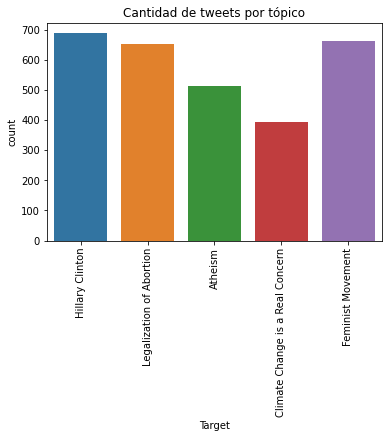

In [ ]:
sns.countplot(train.Target)
plt.xticks(rotation=90)
plt.title("Cantidad de tweets por tópico")

In [ ]:
stances_train['porcentaje'] = stances_train['cantidad']*100/ stances_train.groupby('Target')['cantidad'].transform('sum')
stances_train['porcentaje'] = stances_train['porcentaje'].apply(lambda x: round(x, 2))
stances_train

,Target,Stance,cantidad,porcentaje
0,Atheism,AGAINST,304,59.26
1,Atheism,FAVOR,92,17.93
2,Atheism,NONE,117,22.81
3,Climate Change is a Real Concern,AGAINST,15,3.80
4,Climate Change is a Real Concern,FAVOR,212,53.67
5,Climate Change is a Real Concern,NONE,168,42.53
6,Feminist Movement,AGAINST,328,49.40
7,Feminist Movement,FAVOR,210,31.63
8,Feminist Movement,NONE,126,18.98
9,Hillary Clinton,AGAINST,393,57.04


<Figure size 720x360 with 0 Axes>

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

Text(0.5, 1.0, 'Desbalanceo de Target (% de cada clase)')

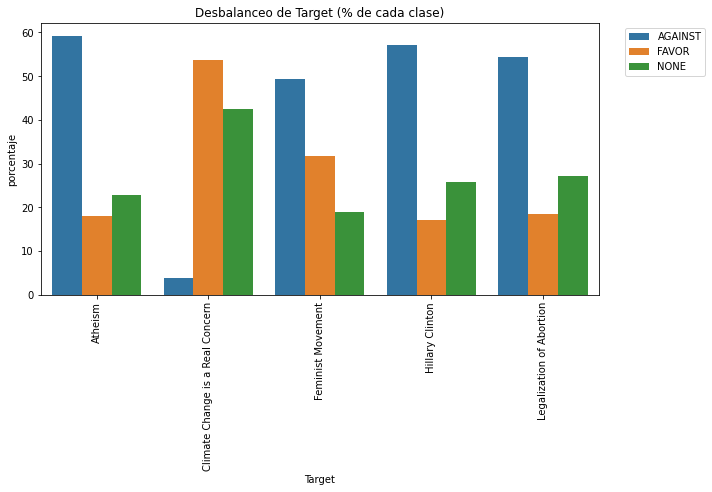

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x="Target", y="porcentaje", hue="Stance", data=stances_train)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.2,1), loc="upper right")
plt.title("Desbalanceo de Target (% de cada clase)")

# Test

In [ ]:
test = pd.read_csv('/content/drive/My Drive/Tweeter/Datasets/test.csv', engine='python')

In [ ]:
test.shape

(1956, 5)

In [ ]:
test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; and he who humbles himself shall be exalted.Matt 23:12. #SemST,Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos
1,"RT @prayerbullets: I remove Nehushtan -previous moves of God that have become idols, from the high places -2 Kings 18:4 #SemST",Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",other
2,@Brainman365 @heidtjj @BenjaminLives I have sought the truth of my soul and found it strong enough to stand on its own merits. #SemST,Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos
3,#God is utterly powerless without Human intervention... #SemST,Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
4,@David_Cameron Miracles of #Multiculturalism Miracles of shady 786 #Taqiya #Tawriya #Jaziya #Kafirs #Dhimmi #Jihad #Allah #SemST,Atheism,AGAINST,2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.,neg


In [ ]:
stances_test = test.groupby(["Target", "Stance"]).size().reset_index()
stances_test.columns = ['Target', 'Stance', 'cantidad']
stances_test

,Target,Stance,cantidad
0,Atheism,AGAINST,160
1,Atheism,FAVOR,32
2,Atheism,NONE,28
3,Climate Change is a Real Concern,AGAINST,11
4,Climate Change is a Real Concern,FAVOR,123
5,Climate Change is a Real Concern,NONE,35
6,Donald Trump,AGAINST,299
7,Donald Trump,FAVOR,148
8,Donald Trump,NONE,260
9,Feminist Movement,AGAINST,183


In [ ]:
test.describe(include = 'all')

,Tweet,Target,Stance,Opinion Towards,Sentiment
count,1956,1956,1956,1956,1956
unique,1956,6,3,3,3
top,Team USA showed the world what American women are capable of! Is Hillary next? #WWC2015 #SemST,Donald Trump,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
freq,1,707,1014,1148,1272


In [ ]:
stances_test['porcentaje'] = stances_test['cantidad']*100/ stances_test.groupby('Target')['cantidad'].transform('sum')
stances_test['porcentaje'] = stances_test['porcentaje'].apply(lambda x: round(x, 2))
stances_test

,Target,Stance,cantidad,porcentaje
0,Atheism,AGAINST,160,72.73
1,Atheism,FAVOR,32,14.55
2,Atheism,NONE,28,12.73
3,Climate Change is a Real Concern,AGAINST,11,6.51
4,Climate Change is a Real Concern,FAVOR,123,72.78
5,Climate Change is a Real Concern,NONE,35,20.71
6,Donald Trump,AGAINST,299,42.29
7,Donald Trump,FAVOR,148,20.93
8,Donald Trump,NONE,260,36.78
9,Feminist Movement,AGAINST,183,64.21


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

Text(0.5, 1.0, 'Cantidad de tweets por tópico')

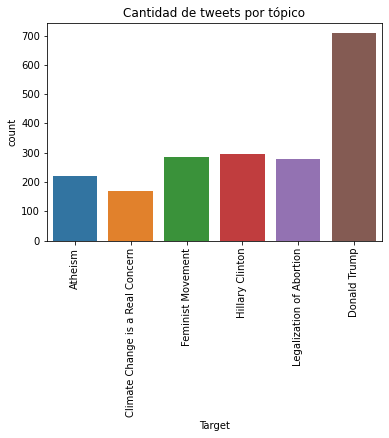

In [ ]:
sns.countplot(test.Target)
plt.xticks(rotation=90)
plt.title("Cantidad de tweets por tópico")

<Figure size 720x360 with 0 Axes>

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

Text(0.5, 1.0, 'Desbalanceo de Target (% de cada clase)')

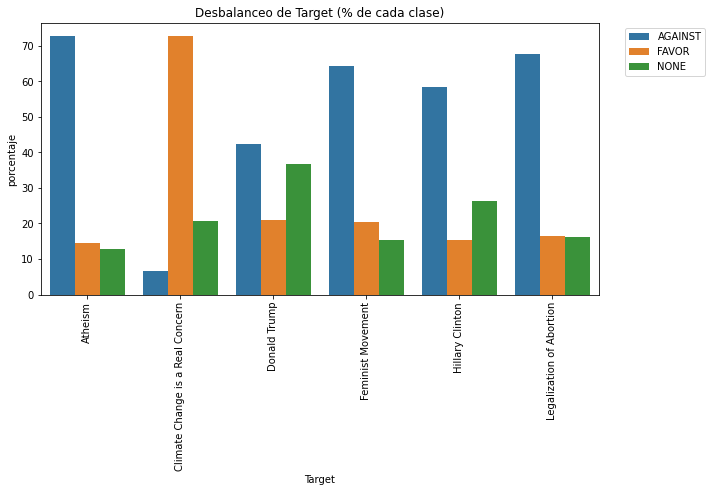

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x="Target", y="porcentaje", hue="Stance", data=stances_test)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.2,1), loc="upper right")
plt.title("Desbalanceo de Target (% de cada clase)")

**Problema de clases desequilibradas**

En el gráfico anterior puede observarse que los tópicos se encuentran desbalanceados. Este problema ocurre porque -para cada tópico- hay clases que tienen un mayor peso relativo dentro del total. Esto podría afectar a futuros experimentos dado que el algoritmo aprendería sobre las clases grandes, ignorando las clases minoritarias.

Estrategias para solucionar el desbalanceo:
- Intentar equilibrar a la clase minoritaria, penalizando a la clase mayoritaria durante el entrenamiento. Para esto habría que ajustar los parámetros del modelo.
- Técnicas de muestreo: una técnica es el sobremuestreo de la clase minoritaria, para aumentar su peso dentro del total. Alternativamente se puede realizar el submuestreo de la clase mayoritaria. El problema de estas técnicas está en que, en el primer caso podríamos llevar al modelo a caer en overfitting, mientras que en segundo caso podríamos estar quitando información relevante de la muestra.

*Ideas para solucionar el problema del desbalanceo:*
https://towardsdatascience.com/yet-another-twitter-sentiment-analysis-part-1-tackling-class-imbalance-4d7a7f717d44

In [ ]:
test["Opinion Towards"].unique()

array(['1.  The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.',
       '2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.',
       '3.  The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)'],
      dtype=object)

### Yapa del Ejercicio 1

Observen esto... qué opinan?

In [ ]:
abortion = test[test["Target"] == "Legalization of Abortion"]
print(abortion.loc[982]["Tweet"], abortion.loc[982]["Stance"])

Those who deny women who've been raped abortion are the same ppl who tell rape victims they asked for it. #rape #SemST AGAINST


Anécdota: cuando empezamos a trabajar con este dataset descubrimos que había un 28% del dataset de test de aborto, un 10% del dataset de train de feminismo y un 16% del dataset de test de feminismo que estaban obsenamente mal clasificados. Todos los que compitieron en la competencia internacional lo hicieron con este dataset incorrecto y nadie lo notó... Nadie se tomó el trabajo de leer los tweets o ver por qué les daban mal las clasificaciones. En la carpeta "Para después del ejercicio 1" van a encontrar tres archivos con los datasets de train y test para feminismo corregidos y test para aborto corregidos. En esta notebook yo voy a seguir trabajando con los datasets originales ya que no debería cambiar mucho los resultados a los efectos de este trabajo. Pero para los siguientes trabajos, les va a cambiar el resultado de sus clasificadores si usan o no usan los datasets corregidos.